<a href="https://colab.research.google.com/github/nyee88/Brilliant/blob/main/Brilliant20250819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install required libraries.
!pip install -q ipympl==0.9.3 matplotlib==3.8.4 scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00


🔄 **Restart Required:**
Please restart the session before running the simulation below.
Go to the menu and click Runtime -> Restart session.
(This is a one-time step required for the interactive widgets to load correctly.)

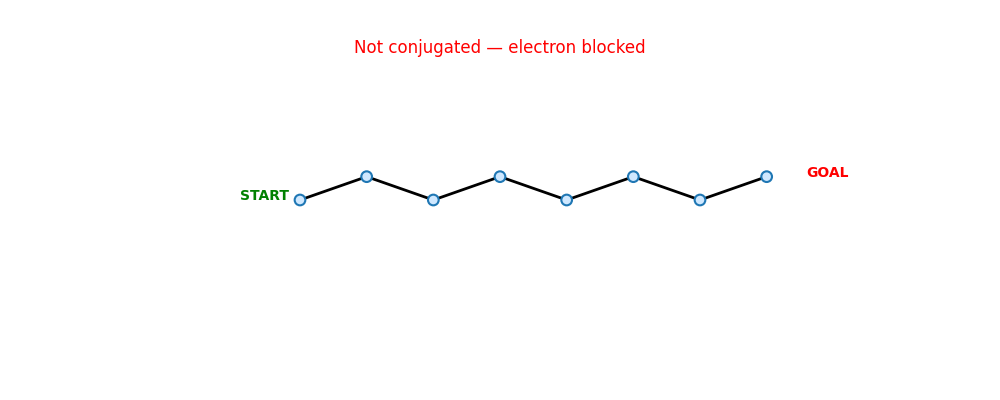

In [2]:
# STEP 3: Run the final, polished simulation.
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from google.colab import output
from matplotlib import colors as mcolors
from scipy.ndimage import gaussian_filter

# This enables the widget manager in the new session
output.enable_custom_widget_manager()

# ------------------- Geometry -------------------
N = 8
# FINAL FIX: Added 0.5 to all x-coordinates to shift the molecule right.
x = np.arange(N, dtype=float) + 0.5
y = np.where(np.arange(N) % 2 == 0, 0.0, 0.35)
coords = np.column_stack([x, y])

bonds = [(i, i+1) for i in range(N-1)]
clickable = {0, 2, 4, 6}
bond_state = np.zeros(len(bonds), dtype=int)

# ------------------- Figure -------------------
fig = plt.figure(figsize=(10, 4))
ax  = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-2.5, N + 1.5)
ax.set_ylim(-2.0, 2.0)
ax.axis('off')

# ------------------- Styles & Parameters -------------------
BLUR_SIGMA = 2.5
SINGLE_LW = 2.0
SINGLE_COLOR = 'black'
DOUBLE_BOND_SEP = 0.08  # Increased from 0.05 to make double bond lines further apart
ATOM_RADIUS, ATOM_EDGE, ATOM_FACE = 0.08, '#1f77b4', '#cfe8ff'
ORBITAL_WIDTH = 2.2  # Increased from 1.8 to make orbitals overlap more
ORBITAL_HEIGHT = 1.0
VERTICAL_OFFSET = ORBITAL_HEIGHT/2 + 0.02
ORBITAL_COLOR, PEAK_ALPHA, GRAD_POWER = "royalblue", 0.35, 1.6
CANVAS_NX, CANVAS_NY = 900, 500
orbitals_img = None

# ------------------- Helpers -------------------
def is_conjugated():
    even = all(bond_state[i] == 1 for i in range(0, len(bonds), 2))
    odd  = all(bond_state[i] == 1 for i in range(1, len(bonds), 2))
    return (even and not any(bond_state[i] for i in range(1, len(bonds), 2))) or \
           (odd and not any(bond_state[i] for i in range(0, len(bonds), 2)))

def status_title():
    ok = is_conjugated()
    ax.set_title("Conjugated — charge can travel" if ok else "Not conjugated — electron blocked",
                 color=('green' if ok else 'red'), pad=10, fontsize=12)

def axes_box():
    return ax.get_xlim() + ax.get_ylim()

def rasterize_orbitals(active_atoms):
    xmin, xmax, ymin, ymax = axes_box()
    X, Y = np.linspace(xmin, xmax, CANVAS_NX), np.linspace(ymin, ymax, CANVAS_NY)
    XX, YY = np.meshgrid(X, Y)
    rgba = np.zeros((CANVAS_NY, CANVAS_NX, 4), dtype=float)
    rgb = np.array(mcolors.to_rgb(ORBITAL_COLOR))

    def add_lobe(cx, cy):
        r2 = ((XX - cx)/(ORBITAL_WIDTH/2))**2 + ((YY - cy)/(ORBITAL_HEIGHT/2))**2
        g = np.clip(1 - r2, 0, 1)**GRAD_POWER
        a = g * PEAK_ALPHA
        # Modified to prevent overlap darkening - use max instead of additive blending
        current_alpha = rgba[..., 3]
        mask = a > current_alpha
        rgba[mask, 0:3] = rgb
        rgba[..., 3] = np.maximum(current_alpha, a)  # This line already prevents darkening

    for ai in active_atoms:
        cx, cy = coords[ai]
        add_lobe(cx, cy + VERTICAL_OFFSET)
        add_lobe(cx, cy - VERTICAL_OFFSET)

    if BLUR_SIGMA > 0:
        rgba[..., 3] = gaussian_filter(rgba[..., 3], sigma=BLUR_SIGMA)
    return rgba, (xmin, xmax, ymin, ymax)

def active_atoms_from_state():
    s = set()
    for i, (a, b) in enumerate(bonds):
        if bond_state[i] == 1: s.add(a); s.add(b)
    return s

# ------------------- Drawing -------------------
def draw_scene():
    global orbitals_img
    ax.cla()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-2.5, N + 1.5); ax.set_ylim(-2.0, 2.0)
    ax.axis('off')

    ax.text(coords[0,0]-0.9, coords[0,1], "START", color='green', weight='bold')
    ax.text(coords[-1,0]+0.6, coords[-1,1], "GOAL", color='red', weight='bold')

    for i, (a, b) in enumerate(bonds):
        p1, p2 = coords[a], coords[b]
        if bond_state[i] == 0:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], lw=SINGLE_LW, color=SINGLE_COLOR, zorder=5)
        else:
            perp = np.array([-(p2[1]-p1[1]), p2[0]-p1[0]]) / np.hypot(*(p2-p1)) * (DOUBLE_BOND_SEP/2)
            ax.plot([p1[0]+perp[0], p2[0]+perp[0]], [p1[1]+perp[1], p2[1]+perp[1]], lw=SINGLE_LW, color=SINGLE_COLOR, zorder=5)
            ax.plot([p1[0]-perp[0], p2[0]-perp[0]], [p1[1]-perp[1], p2[1]-perp[1]], lw=SINGLE_LW, color=SINGLE_COLOR, zorder=5)

    for (cx, cy) in coords:
        ax.add_patch(Circle((cx, cy), ATOM_RADIUS, facecolor=ATOM_FACE, edgecolor=ATOM_EDGE, lw=1.5, zorder=6))

    rgba, extent = rasterize_orbitals(active_atoms_from_state())
    orbitals_img = ax.imshow(rgba, extent=extent, origin='lower', zorder=3, interpolation='bilinear')
    status_title()
    fig.canvas.draw_idle()

# ------------------- Click handling -------------------
CLICK_TOL = 0.15
def dist_point_to_seg(p, a, b):
    v, w = b - a, p - a
    if (L2 := v @ v) == 0: return np.linalg.norm(w)
    t = np.clip((w @ v) / L2, 0, 1)
    return np.linalg.norm(p - (a + t * v))

def on_click(event):
    if not event.inaxes is ax or event.xdata is None: return
    click_pos = np.array([event.xdata, event.ydata])
    distances = [dist_point_to_seg(click_pos, coords[a], coords[b]) if i in clickable else float('inf') for i, (a,b) in enumerate(bonds)]
    best_i = np.argmin(distances)
    if distances[best_i] < CLICK_TOL:
        bond_state[best_i] ^= 1
        draw_scene()

cid_click = fig.canvas.mpl_connect('button_press_event', on_click)

# ------------------- Initial Run -------------------
draw_scene()
plt.show()